In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima_model import ARIMA 
from sklearn.metrics import mean_squared_error

TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data"

dataset = pd.read_csv(os.path.join(TICKER_DIR, "AAPL.csv"))
dataset = dataset.dropna(how="any")
close = dataset["close"].tail(1000)
close

6        99.96
7        97.39
8        99.52
9        97.13
10       96.66
         ...  
1001    284.27
1002    289.91
1003    289.80
1004    291.52
1005    293.65
Name: close, Length: 1000, dtype: float64

In [2]:
def evaluate_arima(X, order):
    size = int(len(X) * 0.6)
    train, test = X[:size], X[size:]
    history = [x for x in train]
    predictions = []
    # perform walk-forward validation
    for t in range(len(test)):
        # fit arima model to the history of values
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=-1)
        # predict the next value
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    error = mean_squared_error(test, predictions)
    return error

In [3]:
def evaluate_models(X, p_values, d_values, q_values):
    scores = []
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima(X, order)
                    scores.append((mse, order))
                    print(f"ARIMA ORDER: {order}\tMSE: {mse}")
                except:
                    continue
    return scores

In [4]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, HessianInversionWarning
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", HessianInversionWarning)

X = dataset["close"].values
scores = evaluate_models(X, [0, 1, 2], range(2), range(2))
best_score = sorted(scores)[0]
print(f"BEST SCORE: {best_score[0]}\tORDER: {best_score[1]}")

ARIMA ORDER: (0, 0, 0)	MSE: 3821.8814001182213
ARIMA ORDER: (0, 0, 1)	MSE: 1033.7350948344583
ARIMA ORDER: (0, 1, 0)	MSE: 11.734324374072088
ARIMA ORDER: (0, 1, 1)	MSE: 11.815273785838126
ARIMA ORDER: (1, 0, 0)	MSE: 11.817900605795554
ARIMA ORDER: (1, 1, 0)	MSE: 11.810913253059034
ARIMA ORDER: (1, 1, 1)	MSE: 11.892296187819516
ARIMA ORDER: (2, 0, 0)	MSE: 11.943224546804979
ARIMA ORDER: (2, 1, 0)	MSE: 11.79766354031549
ARIMA ORDER: (2, 1, 1)	MSE: 11.791101446322925
BEST SCORE: (0, 1, 0)	ORDER: 11.734324374072088


In [14]:
# Try a prediction with the optimal ARIMA parameters
X = dataset["close"].values
model = ARIMA(X, best_score[1])
model_ = model.fit(disp=False)
yhat = model_.forecast()
print(f"Current Value: {X[-1]}\nForecast: {yhat[0]}")

Current Value: 293.65
Forecast: [293.83736318]


In [17]:
model_

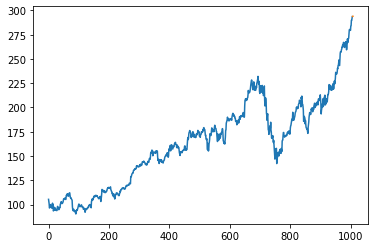

In [12]:
# two step forecast
forecasting = model_.forecast(steps=2)
forecast_vals = forecasting[0]
# reshape the arrays to have the same length
preds = np.zeros(len(X)+len(forecast_vals))
preds[-len(forecast_vals):] = forecast_vals
preds[preds==0] = np.NaN
# plot them on top of each other
plt.plot(X)
plt.plot(preds)

In [ ]:
test_set = pd.read_csv(os.path.join(TICKER_DIR, "MA_BAP.csv"))
test_set = test_set.dropna(how="any")
test_X = test_set["close"].values
scores = evaluate_models(test_X, [0, 1, 2, 4, 6], range(3), range(3))
best_score = sorted(scores)[0]
print(f"BEST SCORE: {best_score[1]}\tORDER: {best_score[0]}")

In [3]:
# Unify all data and normalize them to [0, 1]
# Then perform grid search to find the optimal ARIMA hyperparameters

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data\\_Rolling"
tickers = []
os.getcwd()
cols = ["close"]
for tick in os.listdir(TICKER_DIR):
    path = os.path.join(TICKER_DIR, tick)
    tick_df = pd.read_csv(path, header=0, usecols=cols, squeeze=True)
    tickers.append(tick_df)

df = pd.concat(tickers)
X = df.values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df

array([[0.41735308],
       [0.42277325],
       [0.42311468],
       ...,
       [0.06845632],
       [0.06773078],
       [0.06794418]])

In [4]:
from statsmodels.tsa.arima_model import ARIMA 
from sklearn.metrics import mean_squared_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning, HessianInversionWarning
import warnings

warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", HessianInversionWarning)

possible_orders = ((0, 1, 2, 4, 6), (0, 1, 2), (0, 1, 2))
scores = evaluate_models(scaled_df, [0, 1, 2, 4, 6], range(3), range(3))
# evaluate_arima(scaled_df, (0, 1, 0))

ARIMA ORDER: (0, 0, 0)	MSE: 0.026282427501433427
ARIMA ORDER: (0, 0, 1)	MSE: 0.0076512836084998296
ARIMA ORDER: (0, 1, 0)	MSE: 0.0003019037547837042
ARIMA ORDER: (0, 1, 1)	MSE: 0.00030193748483150297
ARIMA ORDER: (0, 1, 2)	MSE: 0.0003019847439414797
ARIMA ORDER: (0, 2, 0)	MSE: 0.0006024538250254549
ARIMA ORDER: (0, 2, 1)	MSE: 0.00030210259710299677
ARIMA ORDER: (0, 2, 2)	MSE: 0.0003024305351752679
ARIMA ORDER: (1, 0, 0)	MSE: 0.00030115859104032697
ARIMA ORDER: (1, 0, 1)	MSE: 0.0003011833907391868
ARIMA ORDER: (1, 0, 2)	MSE: 0.00030123177428806086
ARIMA ORDER: (1, 1, 0)	MSE: 0.000301939417601608
ARIMA ORDER: (1, 2, 0)	MSE: 0.0004606290157417548
ARIMA ORDER: (1, 2, 1)	MSE: 0.000302133480945515
ARIMA ORDER: (1, 2, 2)	MSE: 0.00030236192926837765
ARIMA ORDER: (2, 0, 0)	MSE: 0.00030118579173162333
ARIMA ORDER: (2, 1, 0)	MSE: 0.0003019846697362073
ARIMA ORDER: (2, 2, 0)	MSE: 0.00041057501490515637
ARIMA ORDER: (2, 2, 1)	MSE: 0.00030260409230600945
ARIMA ORDER: (2, 2, 2)	MSE: 0.000302346406419

In [6]:
a_order = (2, 0, 0)
model = ARIMA(scaled_df, a_order)
model_ = model.fit(disp=False)
yhat = model_.forecast()[0]
print(f"Current Value: {X[-1]}\nForecast: {yhat}")

NameError: name 'scaled_df' is not defined